Need to get hourly or so BTC prices.  

Found this Stackoverflow thread:  
>Actually, you CAN get the whole Bitcoin trades history from Bitcoincharts in CSV format here : > http://api.bitcoincharts.com/v1/csv/

>it is updated twice a day for active exchanges, and there is a few dead exchanges, too.

>EDIT: Since there are no column headers in the CSVs, here's what they are : column 1) the trade's names=None, column 2) the price, column 3) the volume of the trade

  
Downloaded the data for bitstampUSD: 724 Mb unzipped csv.
Let's try

In [37]:
import pandas as pd
import numpy as np
import autopep8

In [39]:
# Matplotlib setup
from __future__ import print_function, division
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go

# Make plotly work with Jupyter notebook
%matplotlib inline
init_notebook_mode()

import cufflinks as cf

# Add error handler that installs cufflinks if this call above fails:
#  ! pip install cufflinks --upgrade

# cf.go_offline()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [3]:
# Run once to fetch the data and filter it to 2017 only

# ADD CONDITION IF ISPATH to skip over this block

# Add the code to download and unzip the data from this URL:

# http://api.bitcoincharts.com/v1/csv/bitstampUSD.csv.gz (this is the 724Mb file)


# inp = pd.read_csv("data/bitstampUSD.csv",names = ["timestamp","price", "volume"])

# inp["date_time"]= pd.to_datetime(inp["timestamp"], unit='s')\
#                  .dt.tz_localize('UTC')\
#                  .dt.tz_convert('America/New_York')
        
# btc = inp[inp["date_time"]>= "2017-01-01"]
# btc.to_csv("processed_data/bitstampUSD_processed_2017.csv",index=False)
# btc.to_pickle("processed_data/bitstampUSD_processed_2017.p")

In [6]:
btc = pd.read_pickle("processed_data/bitstampUSD_processed_2017.p")

In [7]:
btc.head()

,timestamp,price,volume,date_time
10240699,1483228868,966.34,1.46000,2016-12-31 19:01:08-05:00
10240700,1483228873,966.34,1.32000,2016-12-31 19:01:13-05:00
10240701,1483228888,966.34,4.83000,2016-12-31 19:01:28-05:00
10240702,1483228926,966.16,2.38000,2016-12-31 19:02:06-05:00
10240703,1483228926,966.36,2.20029,2016-12-31 19:02:06-05:00


In [ ]:
# Extract time components and initially inspect the dataset

btc["date"] = btc.date_time.dt.date
btc["hour"] = btc.date_time.dt.hour

In [67]:
# Add date time to index and cut out the end of 2016
btc.index = btc.date_time
btc = btc["2017"]

In [99]:
btc_daily_avg = btc.groupby(["date"])["price"].mean()

In [100]:
btc_daily_avg = pd.DataFrame(btc_daily_avg).reset_index() 
btc_daily_avg.head()

,date,price
0,2017-01-01,992.275425
1,2017-01-02,1014.602573
2,2017-01-03,1023.396467
3,2017-01-04,1092.234327
4,2017-01-05,1006.225185


In [101]:
btc_hourly_avg = btc.groupby(["date", "hour"])['price'].mean()
btc_hourly_avg = pd.DataFrame(btc_hourly_avg).reset_index() 
btc_hourly_avg.head()

,date,hour,price
0,2017-01-01,0,963.493846
1,2017-01-01,1,964.462667
2,2017-01-01,2,964.946667
3,2017-01-01,3,964.972222
4,2017-01-01,4,965.049688


#### How did the price development look like in 2017?

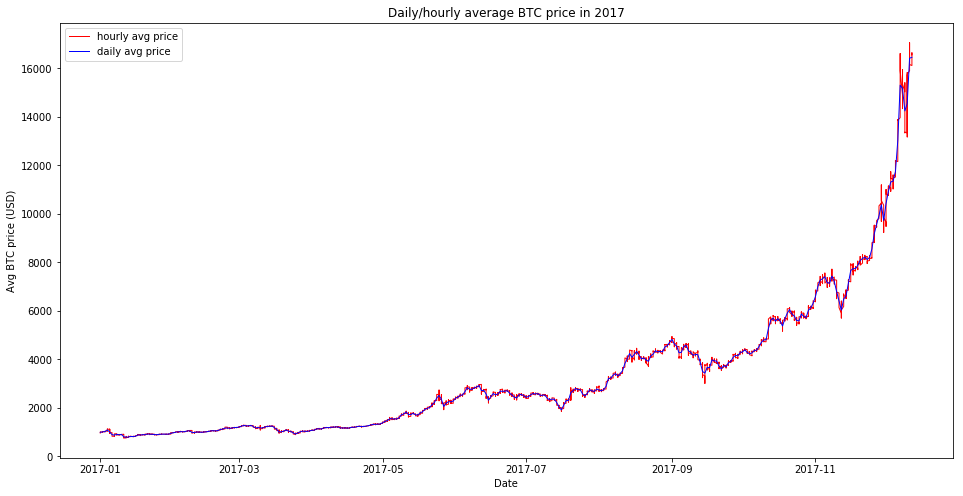

In [102]:
# Make the daily/hourly plot
plt.figure(num=1, figsize=(16, 8)) 
plt.plot(btc_hourly_avg["date"], btc_hourly_avg["price"], linewidth=1,
         color="red", label=r"hourly avg price")
plt.xlabel(r"Date")
plt.ylabel(r"Avg BTC price (USD)")
plt.title(r"Daily/hourly average BTC price in 2017")


plt.plot(btc_daily_avg["date"], btc_daily_avg["price"], linewidth=1,
         color="blue", label=r"daily avg price")

plt.legend(loc="upper left")

plt.show()

#### Did the price increase or decrease at the close of the day?

In [103]:
btc_ohlc = btc.groupby("date")["price"].agg({"open" : "first","high": "max",
                                              "low":"min","close" : "last",
                                              "median":"median"})

conditions = [(btc_ohlc['open'] <= btc_ohlc['close'])
              ,(btc_ohlc['open'] > btc_ohlc['close'])
             ]
choices = ["up","down"]

btc_ohlc['price_change'] = np.select(conditions, choices)


/Users/dima/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version



In [104]:
btc_ohlc.head(10)

,open,high,low,close,median,price_change
date,,,,,,
2017-01-01,963.02,1005.75,962.80,1005.73,997.625,up
2017-01-02,1005.48,1032.00,990.01,1023.57,1014.920,up
2017-01-03,1023.59,1046.00,1009.08,1042.64,1020.290,up
2017-01-04,1042.34,1139.89,1038.35,1118.05,1090.980,up
2017-01-05,1118.05,1136.72,885.41,970.10,983.500,down
2017-01-06,969.92,989.97,821.22,836.74,894.860,down
2017-01-07,837.48,938.00,812.28,937.05,885.010,up
2017-01-08,938.00,941.81,875.00,884.65,908.340,down
2017-01-09,885.01,910.58,879.94,895.62,894.250,up


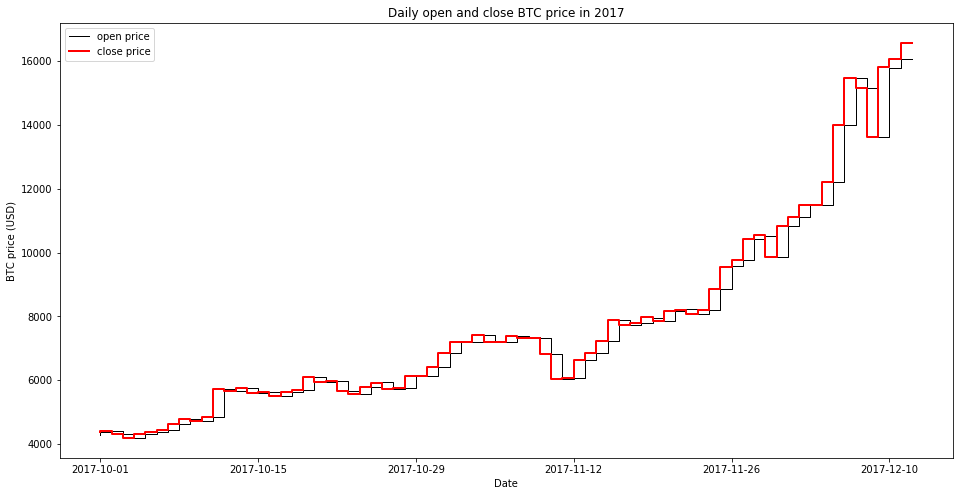

In [146]:
# Make the o-c plot
df = btc_ohlc[pd.to_datetime("2017-10-01").date():]

plt.figure(num=1, figsize=(16, 8)) 
plt.step(df.index, df["open"], linewidth=1,
         color="black", label=r"open price")
plt.xlabel(r"Date")
plt.ylabel(r"BTC price (USD)")
plt.title(r"Daily open and close BTC price in 2017")

plt.step(df.index, df["close"], linewidth=2,
         color="red", label=r"close price")

# plt.bar(x=df.index, height=df["close"], color = "grey", width = -0.4,align="center")
plt.legend(loc="upper left")

plt.show()

### Reference

https://pandas.pydata.org/pandas-docs/stable/index.html  
http://mple.m-artwork.eu/tutorial  
Pandas Ifelse selection https://stackoverflow.com/a/19913845/8066374  